In [1]:
import torch
from torch import nn

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def split_image_into_patches(image_path):
    img = Image.open(image_path)

    img = img.resize((224, 224))
    
    width, height = img.size

    patches = []
    for i in range(0, height, 16):
        row_patches = []
        for j in range(0, width, 16):
            left = j
            upper = i
            right = min(j + 16, width)
            lower = min(i + 16, height)
            patch = img.crop((left, upper, right, lower))
            row_patches.append(patch)
        patches.append(row_patches)
    return patches

In [3]:
def visualize_patches(image_path):
    # Read image
    original_image = Image.open(image_path)

    # Split image
    patches = split_image_into_patches(image_path)

    # Visualize original image
    plt.figure(figsize=(10,10))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')

    # Visualize patches
    plt.subplot(1, 2, 2)
    plt.title('Patches')
    for i, row_patches in enumerate(patches):
        for j, patch in enumerate(row_patches):
            plt.subplot(len(patches), len(row_patches), i*len(row_patches) + j + 1)
            plt.imshow(patch)
            plt.axis('off')

    # Show plot
    plt.show()


In [4]:
image_path = "./assets/waterfall.jpeg"
patches = split_image_into_patches(image_path)


/var/folders/qb/39vyw_3n0xs2twkkm6lv__y00000gn/T/ipykernel_93916/3277867385.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(patches), len(row_patches), i*len(row_patches) + j + 1)


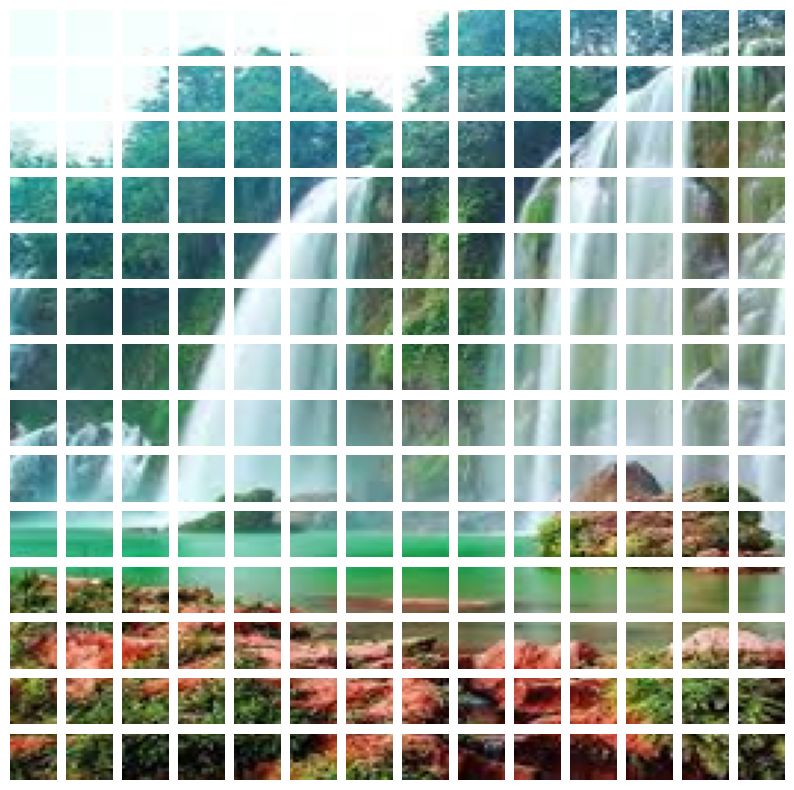

In [5]:
visualize_patches(image_path)

In [6]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        super().__init__()
        self.patch_size = patch_size
        self.projection = nn.Sequential(
            # Break image up into patches
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2),
            # Transposition is removed
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((32 * 32) // patch_size ** 2 + 1, emb_size))

    def forward(self, x: torch.Tensor):
        # Create patch embeddings
        embeddings = self.projection(x)
        # Transposition is done here using Tensor.permute
        embeddings = embeddings.permute(0, 2, 1)
        batch_size, _, _ = embeddings.shape

        # Add cls token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        embeddings = torch.cat((cls_tokens, embeddings), dim=1)

        # Add position embeddings
        embeddings = embeddings + self.positions
        return embeddings


In [7]:
class Transformer(nn.Module):
    def __init__(self, emb_size: int = 768, nhead: int = 8, num_layers: int = 12, num_classes: int = 1000):
        super().__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=emb_size, nhead=nhead),
            num_layers=num_layers
        )
        self.fc = nn.Linear(emb_size, num_classes)

    def forward(self, x: torch.Tensor):
        x = self.transformer(x)
        x = self.fc(x.mean(dim=1))
        return x


In [8]:
from torchvision import datasets

# Transformations: ToTensor and Normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset, apply transformations
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)



NameError: name 'transforms' is not defined

In [ ]:
import torch.optim as optim

# Hyperparameters
lr = 1e-4
epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model, Loss, Optimizer
patch_emb = PatchEmbedding().to(device)
transformer = Transformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(patch_emb.parameters()) + list(transformer.parameters()), lr=lr)

for epoch in range(epochs):
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Pass images through patch embedding
        embeddings = patch_emb(images)

        # Pass embeddings through transformer
        outputs = transformer(embeddings)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if (idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{idx+1}/{len(train_loader)}], Loss: {loss.item()}')

print('Finished Training.')